In [1]:
import numpy as np
import mne

In [2]:
microstate_maps = np.load("./dataset/microstate_maps.npy")

In [3]:
eeg_raw = mne.io.read_raw('C:/Users/Micro/Desktop/MainResearchProjects/eeg-language/data/dataset1/Raw_EDF_Files/p10_Record1.edf') #list(eeg_raw.values())[0]

Extracting EDF parameters from C:\Users\Micro\Desktop\MainResearchProjects\eeg-language\data\dataset1\Raw_EDF_Files\p10_Record1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
SOP = 30 * 60 # seizure occurrance period (s)
SPH = 5 * 60 # seizure prediction horizon

In [5]:
freq = 500
total_length = freq * SOP

In [6]:
data = eeg_raw.get_data().T

In [7]:
# Clip the data. (Extract the seizure occurrance period)

record_start = (5, 36, 39) # hour, minute, seconds.

seizure1 = (7, 36, 38)  # hour, minute, seconds.
seizure1_start = ((seizure1[0] - record_start[0]) * 3600 + (seizure1[1] - record_start[1]) * 60 + (seizure1[2] - record_start[2])) * freq
seizure1_length = (60 * 7 + 25) * freq
seizure1_end = seizure1_start + seizure1_length

# clip
seizure_mid = (seizure1_start + seizure1_end) // 2
clip_left = (seizure_mid - total_length // 2)
clip_right = (seizure_mid + total_length // 2)
additional_offset = 0

# Right moving the fragment, if `clip_left` < 0 (seizure happens < 15 minute from the beginning of record.). 
# This operation aims at making prediction area as large as possible.
if (clip_left < 0):
    max_movable_length = seizure1_end - seizure_mid + (seizure1_length // 2)
    additional_offset = min(abs(clip_left), max_movable_length)
    clip_left += additional_offset
    clip_right += additional_offset
    
train_data = data[clip_left: clip_right, :]
seizure_offset = (total_length // 2) - ((seizure1_end - seizure1_start) // 2) + additional_offset

In [8]:
a = (train_data.dot(microstate_maps.T)) ** 2
microstate_sequence = np.argmax(a, axis = 1)
del train_data

In [9]:
del data

In [10]:
states = []
m = 50
for i in range(m, len(microstate_sequence)):
    states.append(microstate_sequence[i - m: i])

In [11]:
states = np.array(states)
states

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 1]], dtype=int64)

In [12]:
from sklearn.manifold import TSNE

In [ ]:
X_embedded = TSNE(n_components=3, learning_rate = 'auto',
                  init='random', perplexity=3).fit_transform(states)

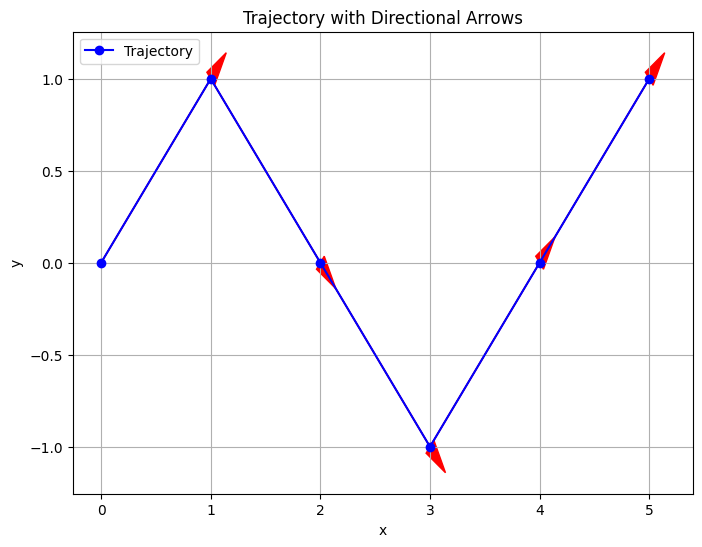

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Trajectory')

# Add directional arrows
for i in range(len(x) - 1):
    plt.arrow(x[i], y[i], x[i+1] - x[i], y[i+1] - y[i],
              head_width=0.1, head_length=0.2, fc='r', ec='r')

plt.title('Trajectory with Directional Arrows')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()